In [7]:
#Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import os
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [84]:
#Set up data with following aspect: Date, Close_price, Open_price, High_price, Low_price, Trading volume
def getData(data):
    df = pd.read_csv(data)
    return df

# #Case #1 compare stocks
# aapl = getData("AAPL_price.csv")
# amzn = getData("AMZN_price.csv")
# bmrn = getData("BMRN_price.csv")
# google = getData("GOOGL_price.csv")

#Case #2 Compare indices between nasdaq and nikei
# nasdaq = getData("IXIC.csv")
# nikei = getData("N225.csv")
nasdaq = getData("N225.csv")


# Data Cleaning

In [85]:

# Check the percentage of the missing data from the given dataset
# If missing data is less than 5% --> Remove the missing values
# Else --> Impute missing data with midpoint of nearby data

def missing_count(data):
    missing_count = data.isnull().sum() / data.count()
    if missing_count["Adj Close"] < 0.05: 
        data.dropna(inplace=True)
    else:
        data = data.interpolate() # Takes the midpoint between the points
    return data

# Ensure there are no duplicates
def drop_duplicate(data):
    newData = data.drop_duplicates(subset='Date')
    return newData

nasdaq = missing_count(nasdaq)
nasdaq = drop_duplicate(nasdaq)



In [86]:
#Test (Deal with data after 1985 ) 
def getDate(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['year'] = data['Date'].dt.year
    data= data.loc[data['year'] >= 1985]
    return data

nasdaq = getDate(nasdaq)
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year
5216,1985-01-02,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,0.0,1985
5218,1985-01-04,11558.059570,11558.059570,11558.059570,11558.059570,11558.059570,0.0,1985
5219,1985-01-07,11575.519531,11575.519531,11575.519531,11575.519531,11575.519531,0.0,1985
5220,1985-01-08,11679.790039,11679.790039,11679.790039,11679.790039,11679.790039,0.0,1985
5221,1985-01-09,11763.570313,11763.570313,11763.570313,11763.570313,11763.570313,0.0,1985


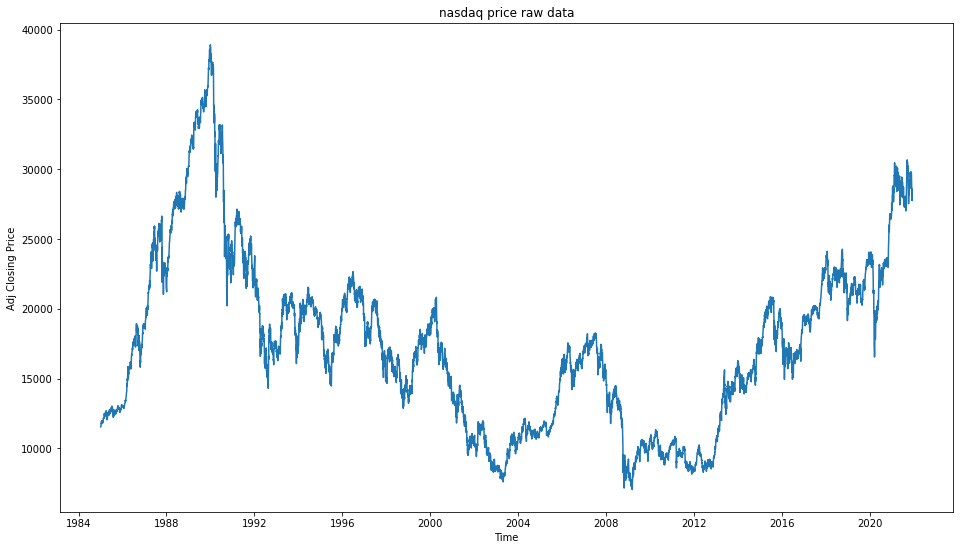

In [43]:
# Graph raw data
def getGraph(data, title):
    plt.figure(figsize=(16, 9))
    plt.plot(data['Date'], data['Adj Close'])
    plt.xlabel('Time')
    plt.ylabel('Adj Closing Price')
    plt.title(title + " price raw data")
    plt.show()
    # plt.savefig('raw_data.png')

getGraph(nasdaq, "nasdaq")


# Noise Filtering

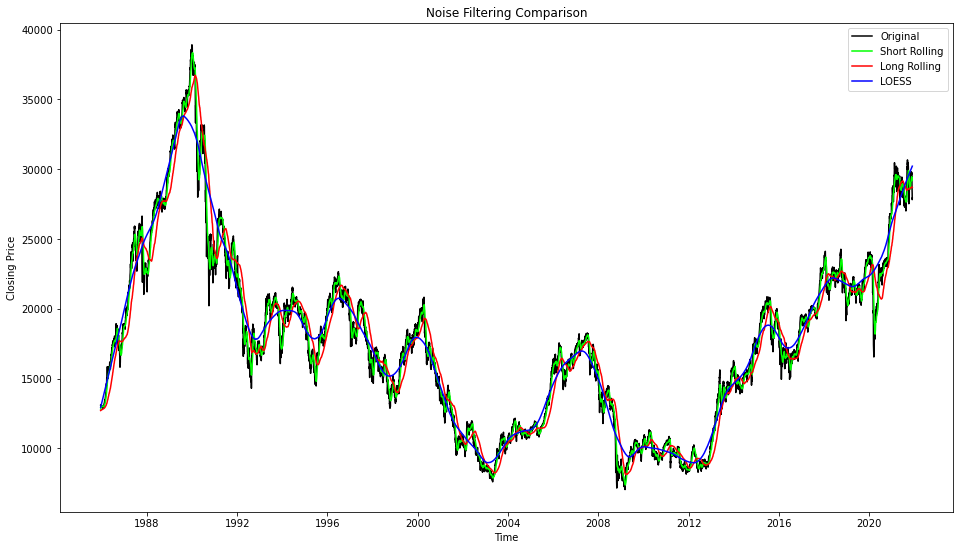

In [88]:
def rolling_mean(data):
    # 1. Rolling mean
    short_data = data
    short_data['short_rolling'] = data['Adj Close'].shift(-1).rolling(window=20).mean()
    short_data.dropna(inplace=True)

    long_data = data
    long_data['long_rolling'] = data['Adj Close'].shift(-1).rolling(window=100).mean()
    long_data.dropna(inplace=True)
    return short_data, long_data

def graph_noise_filter(data):
    plt.figure(figsize=(16, 9))
    plt.plot(data['Date'], data['Adj Close'], color='black', linewidth=1.5)	# Original data
    plt.plot(data['Date'], short_data['short_rolling'], color='lime', label='20-days SMA')
    plt.plot(data['Date'], long_data['long_rolling'], color='red', label='100-days SMA')

    # 2. LOESS
    filtered = lowess(data['Adj Close'], data['Date'], frac=0.05)
    plt.plot(data['Date'], filtered[:, 1], color='blue')

    plt.legend(['Original', 'Short Rolling', 'Long Rolling', 'LOESS'])
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.title('Noise Filtering Comparison')
    plt.show()
    # plt.savefig('noise_filtering.png')

short_data, long_data = rolling_mean(nasdaq)
graph_noise_filter(nasdaq)

# Machine Learning: Regression Models

## Linear Regression - Short Rolling

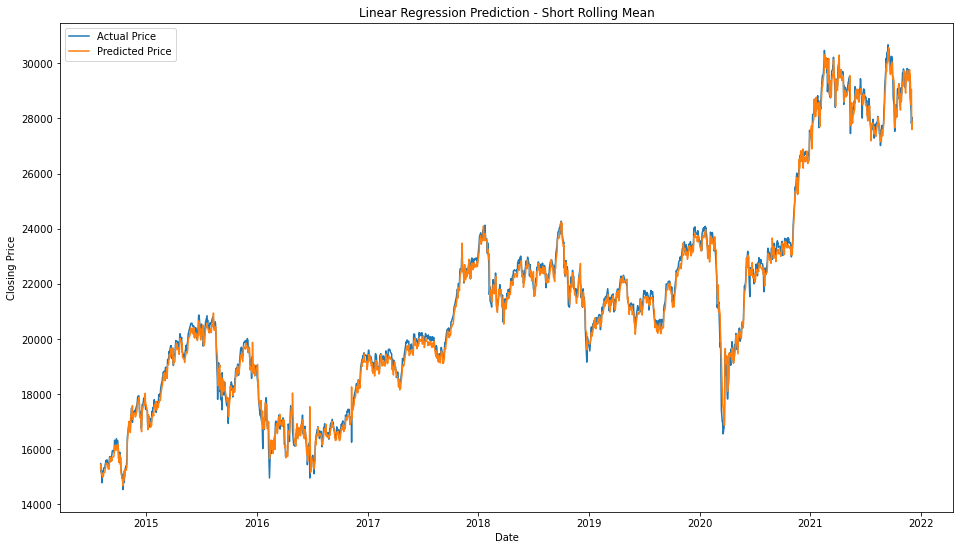

0.9946509603904252 0.9808844588819139


In [45]:
def shortrolling_train_test_split(data):
    X = data[['Open', 'High', 'Low', 'Volume']]
    y_short = short_data['short_rolling']
    t = int(0.8*len(data))
    X_train = X[:t]
    X_test = X[t:]
    y_short_train = y_short[:t]
    y_short_test = y_short[t:]
    return X_train, X_test, y_short_train, y_short_test

X_train, X_test, y_short_train, y_short_test = shortrolling_train_test_split(nasdaq)

def short_linear_model(data):
    lin_model = make_pipeline(
        MinMaxScaler(),
        LinearRegression()
    )
    lin_model.fit(X_train, y_short_train)
    predictions = lin_model.predict(X_test) # Predict a model
    train_score = lin_model.score(X_train, y_short_train)
    test_score = lin_model.score(X_test, y_short_test)

    # Making DataFrame for the predictions & Joining
    linear_pred_short = pd.DataFrame(predictions, index=y_short_test.index, columns=['Linear_pred_short'])
    join_pred = data.join(linear_pred_short, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Linear_pred_short'],  label='Predicted Price')
    plt.title('Linear Regression Prediction - Short Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.show()

    return train_score, test_score, linear_pred_short

short_linear_train_score, short_linear_test_score, linear_pred_short = short_linear_model(nasdaq)
print(short_linear_train_score, short_linear_test_score)

## Linear Regression - Long Rolling

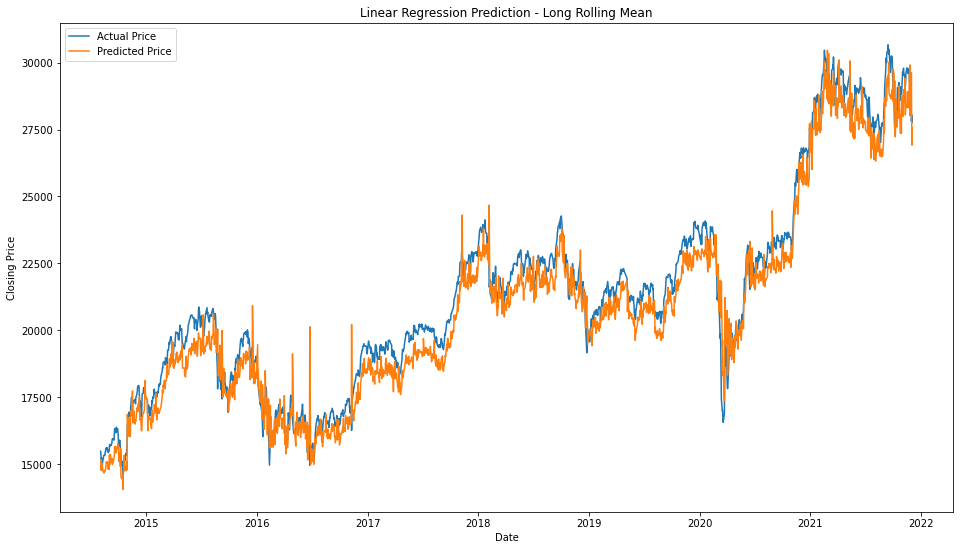

0.9657172070877389 0.8947416756330231


In [46]:
def longrolling_train_test_split(data):
    X = data[['Open', 'High', 'Low', 'Volume']]
    y_long = long_data['long_rolling']
    t = int(0.8*len(data))
    X_train = X[:t]
    X_test = X[t:]
    y_long_train = y_long[:t]
    y_long_test = y_long[t:]
    return X_train, X_test, y_long_train, y_long_test

X_train, X_test, y_long_train, y_long_test = longrolling_train_test_split(nasdaq)

def long_linear_model(data):
    lin_model = make_pipeline(
        MinMaxScaler(),
        LinearRegression()
    )
    lin_model.fit(X_train, y_long_train)
    predictions = lin_model.predict(X_test) # Predict a model
    train_score = lin_model.score(X_train, y_long_train)
    test_score = lin_model.score(X_test, y_long_test)

    # Making DataFrame for the predictions & Joining
    linear_pred_long = pd.DataFrame(predictions, index=y_long_test.index, columns=['Linear_pred_long'])
    join_pred = data.join(linear_pred_long, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Linear_pred_long'],  label='Predicted Price')
    plt.title('Linear Regression Prediction - Long Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.show()

    return train_score, test_score, linear_pred_long

long_linear_train_score, long_linear_test_score, linear_pred_long = long_linear_model(nasdaq)
print(long_linear_train_score, long_linear_test_score)

## K-nearest Neighbour Regression - Short Rolling

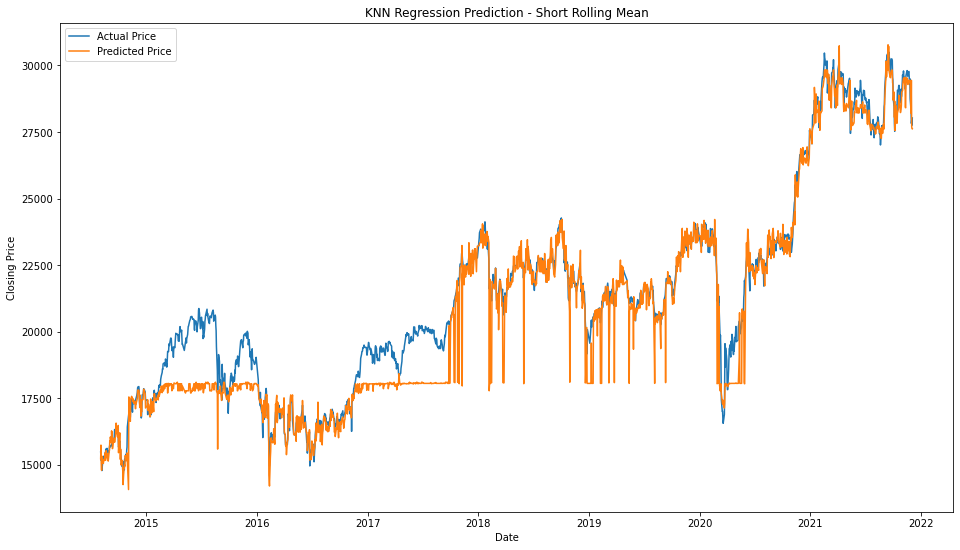

0.9960684845119455 0.9098067039615595


In [47]:
def short_knn_model(data):
    # Training & Test data defined above already
    knn_model = make_pipeline(
        MinMaxScaler(),
        KNeighborsRegressor(n_neighbors=5)
    )
    knn_model.fit(X_train, y_short_train)
    knn_pred = knn_model.predict(X_test) # Predict a model
    train_score = knn_model.score(X_train, y_short_train)
    test_score = knn_model.score(X_test, y_short_test)

    # Making DataFrame for the predictions & Joining
    knn_pred_short = pd.DataFrame(knn_pred, index=y_short_test.index, columns=['Knn_pred_short'])
    join_pred = data.join(knn_pred_short, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Knn_pred_short'], label='Predicted Price')
    plt.title('KNN Regression Prediction - Short Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.show()

    return train_score, test_score, knn_pred_short

short_knn_train_score, short_knn_test_score, knn_pred_short = short_knn_model(nasdaq)
print(short_knn_train_score, short_knn_test_score)

## K-nearest Neighbour Regression - Long Rolling

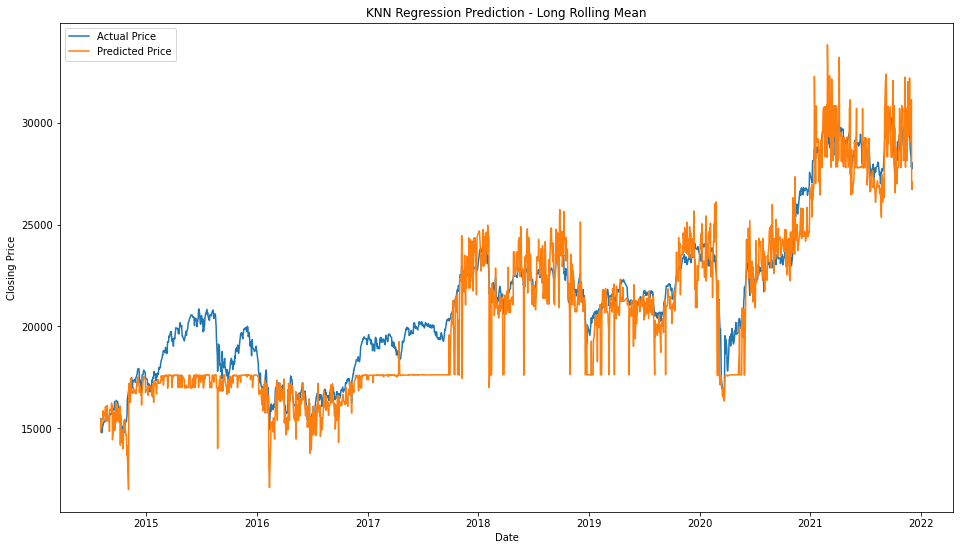

0.9782066980723612 0.7019930763143687


In [49]:
def long_knn_model(data):
    # Training & Test data defined above already
    knn_model = make_pipeline(
        MinMaxScaler(),
        KNeighborsRegressor(n_neighbors=5)
    )
    knn_model.fit(X_train, y_long_train)
    knn_pred = knn_model.predict(X_test) # Predict a model
    train_score = knn_model.score(X_train, y_long_train)
    test_score = knn_model.score(X_test, y_long_test)

    # Making DataFrame for the predictions & Joining
    knn_pred_long = pd.DataFrame(knn_pred, index=y_long_test.index, columns=['Knn_pred_long'])
    join_pred = data.join(knn_pred_long, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['Knn_pred_long'], label='Predicted Price')
    plt.title('KNN Regression Prediction - Long Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.show()

    return train_score, test_score, knn_pred_long

long_knn_train_score, long_knn_test_score, knn_pred_long = long_knn_model(nasdaq)
print(long_knn_train_score, long_knn_test_score)

## Random Forest Regression - Best Parameters

In [54]:
def short_rf_parameters():
    # Short Rolling
    grid = {'n_estimators': [500], 'max_depth': [30], 'min_samples_leaf': [20]}
    test_scores = []

    rf_model = RandomForestRegressor()

    for g in ParameterGrid(grid):
        rf_model.set_params(**g) 
        rf_model.fit(X_train, y_short_train)
        test_scores.append(rf_model.score(X_test, y_short_test))

    best_index = np.argmax(test_scores)
    print(test_scores[best_index], ParameterGrid(grid)[best_index])

def long_rf_parameters():
    # Long Rolling
    grid = {'n_estimators': [500], 'max_depth': [30], 'min_samples_leaf': [20]}
    test_scores = []

    rf_model = RandomForestRegressor()

    for g in ParameterGrid(grid):
        rf_model.set_params(**g) 
        rf_model.fit(X_train, y_long_train)
        test_scores.append(rf_model.score(X_test, y_long_test))

    best_index = np.argmax(test_scores)
    print(test_scores[best_index], ParameterGrid(grid)[best_index])

short_rf_parameters()
long_rf_parameters()

0.9742637936907838 {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 30}
0.7473546914499336 {'n_estimators': 500, 'min_samples_leaf': 20, 'max_depth': 30}


## Random Forest Regression - Short Rolling

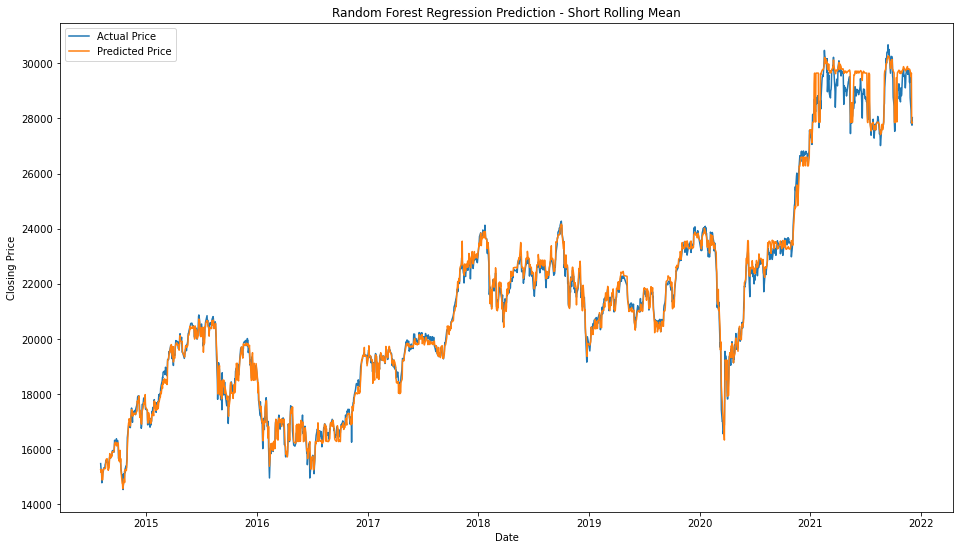

0.9950781880572457 0.9731745417106242


In [55]:
def short_rf_model(data):
    # Training & Test data defined above already
    rf_model = make_pipeline(
        MinMaxScaler(),
        RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=30)
    )
    rf_model.fit(X_train, y_short_train)
    rf_pred = rf_model.predict(X_test) # Predict a model
    train_score = rf_model.score(X_train, y_short_train) 
    test_score = rf_model.score(X_test, y_short_test) 

    # Making DataFrame for the predictions & Joining
    rf_pred_short = pd.DataFrame(rf_pred, index=y_short_test.index, columns=['rf_pred_short'])
    join_pred = data.join(rf_pred_short, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['rf_pred_short'], label='Predicted Price')
    plt.title('Random Forest Regression Prediction - Short Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.show()

    return train_score, test_score, rf_pred_short

short_rf_train_score, short_rf_test_score, rf_pred_short = short_rf_model(nasdaq)
print(short_rf_train_score, short_rf_test_score)

## Random Forest Regression - Long Rolling

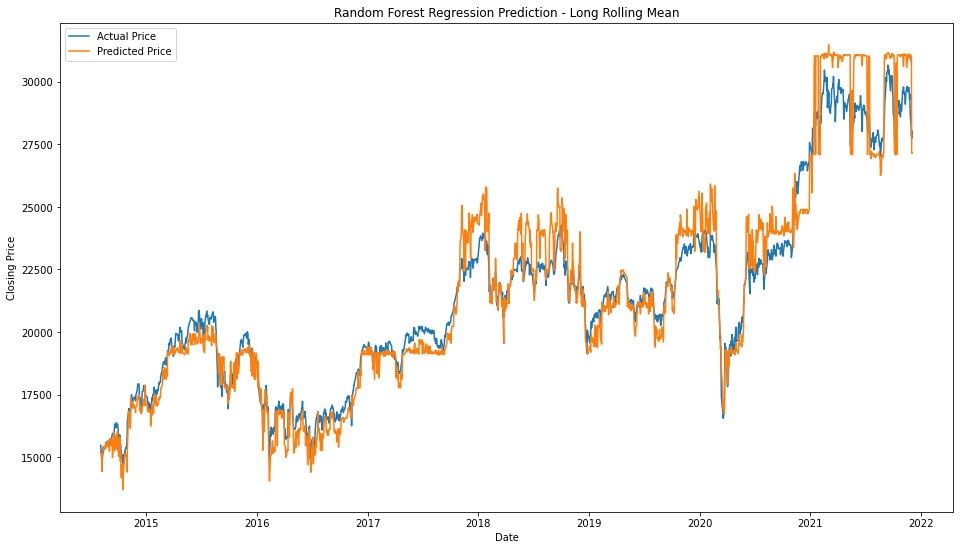

0.9704044388471428 0.7407498475361207


In [53]:
def long_rf_model(data):
    # Training & Test data defined above already
    rf_model = make_pipeline(
        MinMaxScaler(),
        RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_leaf=30)
    )
    rf_model.fit(X_train, y_long_train)
    rf_pred = rf_model.predict(X_test) # Predict a model
    train_score = rf_model.score(X_train, y_long_train) # Short - 0.997828, Long - 0.987426
    test_score = rf_model.score(X_test, y_long_test) # Short - 0.992788, Long - 0.966242

    # Making DataFrame for the predictions & Joining
    rf_pred_long = pd.DataFrame(rf_pred, index=y_long_test.index, columns=['rf_pred_long'])
    join_pred = data.join(rf_pred_long, how='inner')

    plt.figure(figsize=(16, 9))
    plt.plot(join_pred['Date'], join_pred['Close'], label='Actual Price')
    plt.plot(join_pred['Date'], join_pred['rf_pred_long'], label='Predicted Price')
    plt.title('Random Forest Regression Prediction - Long Rolling Mean')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend(loc='upper left')
    plt.show()

    return train_score, test_score, rf_pred_long

long_rf_train_score, long_rf_test_score, rf_pred_long = long_rf_model(nasdaq)
print(long_rf_train_score, long_rf_test_score)

## Machine Learning Models Failure Analysis

In [75]:
# Print the descriptive statistics of each model to check the range

def model_statistic():
    linear_range = linear_pred_short.describe()
    knn_range = knn_pred_short.describe()
    rf_range = rf_pred_short.describe()
    
    model_stats = pd.merge(linear_range, knn_range, left_index=True, right_index=True)
    model_stats = model_stats.merge(rf_range, left_index=True, right_index=True)
    model_stats = model_stats.rename(
        columns={"Linear_pred_short": "Linear_Regression", 
                 "Knn_pred_short": "KNN", 
                 "rf_pred_short": "Random_Forest"})
    
    return model_stats

model_stats = model_statistic()
print(model_stats)

       Linear_Regression           KNN  Random_Forest
count        1792.000000   1792.000000    1792.000000
mean        21226.263998  20787.878866   21358.357363
std          3722.631725   3933.190122    3863.030276
min         14672.486469  14064.518818   14566.627110
25%         18783.344292  17853.027266   18521.154084
50%         20873.897100  20559.030313   20937.148536
75%         22770.949329  23010.748975   23097.025976
max         30566.087845  30777.082891   30265.190708


In [72]:
# Print the descriptive statistics of original data for comparison

def data_statistic(data):
    data_range = data['short_rolling'].describe()
    train_data_range = y_short_train.describe()

    original_stats = pd.DataFrame({
        'raw_data': data_range,
        'train_data': train_data_range,
    })
    
    return original_stats

original_stats = data_statistic(nasdaq)
print(original_stats)

           raw_data    train_data
count   8956.000000   7164.000000
mean   17590.804135  16674.772412
std     6258.158681   6429.867095
min     7384.125000   7384.125000
25%    12747.448914  11294.144946
50%    17120.300537  16081.344263
75%    21005.912402  19929.425952
max    38345.544922  38345.544922


# Deep Learning - LSTM

## Data Pre-processing

In [90]:
closePriceShort = short_data['short_rolling'].astype("float32")
closePriceLong = long_data["long_rolling"].astype("float32")
train_Short = closePriceShort[0:int(len(closePriceShort)*0.8)]
train_Long = closePriceLong[0:int(len(closePriceLong)*0.8)]


In [91]:
# LSTM Data normalization
#We have to sacle our data for optimal performance
sc = MinMaxScaler(feature_range = (-1,1))
training_set_scaled = sc.fit(train_Short.values.reshape(-1,1))
closePrice = sc.transform(closePriceShort.values.reshape(-1,1))





In [92]:
'''
Our train data will have as features the look back values, which are the lag values noted as ‘lb’.
For this example, we set the lb equal to 10. Notice that we scale the data on the “train” dataset
using the MinMaxScaler() from scikit-learn. Finally, for this example, we keep as train dataset
the first 90% of the observations and as a test dataset the rest 10%
'''
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

lb=10
X,y = processData(closePrice,lb)
X,y = processData(closePrice,lb)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])


7060 10
1765 10
7060
1765


In [95]:
#Need to install Tensorflow
#pip install --upgrade tensorflow
#pip install keras
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1,))
model.compile(optimizer='adam',loss='mse', metrics=('acc'))

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),shuffle=True)
model.summary() 


NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

Text(0.5, 1.0, 'Train Dataset')

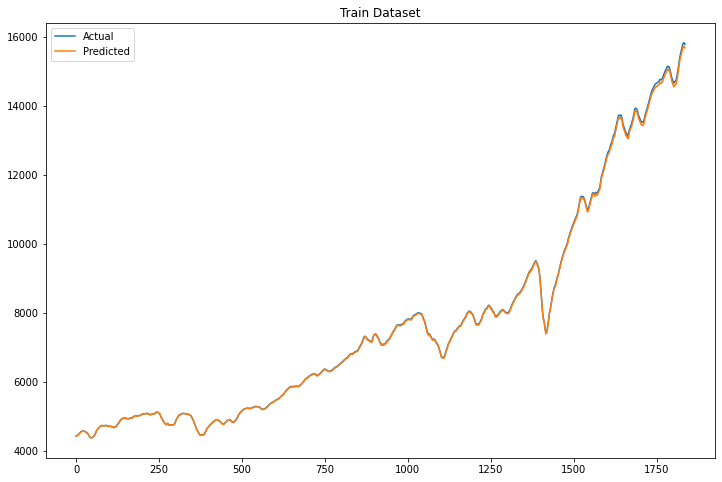

In [20]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_test)

plt.plot(sc.inverse_transform(y_test.reshape(-1,1)),label="Actual")
plt.plot(sc.inverse_transform(Xt),label="Predicted")
plt.legend()
plt.title("Train Dataset")

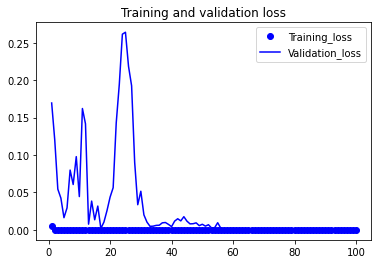

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
[0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266690850258, 0.00013620266

In [21]:
#Loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training_loss")
plt.plot(epochs, val_loss, "b", label = "Validation_loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# print("The accuracy is {}".format(val_accuracy))
print(history.history.keys())
print(history.history["acc"])